# Computer Hardware Regression Project

---

## Imports

In [282]:
import os
from IPython.core.display import display

import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style='ticks')

import plotly
import plotly.express as px

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import scipy
from scipy.stats import boxcox


---

## Load Data

In [283]:
data_path = os.getcwd() + os.sep + 'machine.data'
col_names = ['vendor_name',
             'model_name',
             'myct',
             'mmin',
             'mmax',
             'cach',
             'chmin',
             'chmax',
             'prp',
             'erp']

df = pd.read_csv(data_path, names=col_names)

---

## EDA

### Dataset Inspection

In [284]:
df.head()

,vendor_name,model_name,myct,mmin,mmax,cach,chmin,chmax,prp,erp
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


More information on what each of the columns in this dataset mean can be found in the ```machine.names``` file.

For our purposes, we should understand that the ```prp```, or "Published Relative Performance", column represents the
CPU's performance, and is our target for this project.

The ```erp```, or "Estimated Relative Performance", column represents the dataset's author's regression prediction.

Let's store these ```erp``` predictions elsewhere for now, and we can use them at the end of this project to compare our
best regression solution to the author's.

In [285]:
erp = list(df.pop('erp'))
print(erp)

[199, 253, 253, 253, 132, 290, 381, 381, 749, 1238, 23, 24, 70, 117, 15, 64, 23, 29, 22, 124, 35, 39, 40, 45, 28, 21, 28, 22, 28, 27, 102, 102, 74, 74, 138, 136, 23, 29, 44, 30, 41, 74, 74, 74, 54, 41, 18, 28, 36, 38, 34, 19, 72, 36, 30, 56, 42, 34, 34, 34, 34, 34, 19, 75, 113, 157, 18, 20, 28, 33, 47, 54, 20, 23, 25, 52, 27, 50, 18, 53, 23, 30, 73, 20, 25, 28, 29, 32, 175, 57, 181, 181, 32, 82, 171, 361, 350, 220, 113, 15, 21, 35, 18, 20, 20, 28, 45, 18, 17, 26, 28, 28, 31, 31, 42, 76, 76, 26, 59, 65, 101, 116, 18, 20, 20, 30, 44, 44, 82, 82, 128, 37, 46, 46, 80, 88, 88, 33, 46, 29, 53, 53, 41, 86, 95, 107, 117, 119, 120, 48, 126, 266, 270, 426, 151, 267, 603, 19, 21, 26, 35, 41, 47, 62, 78, 80, 80, 142, 281, 190, 21, 25, 67, 24, 24, 64, 25, 20, 29, 43, 53, 19, 22, 31, 41, 47, 99, 67, 81, 149, 183, 275, 382, 56, 182, 227, 341, 360, 919, 978, 24, 24, 24, 24, 37, 50, 41, 47, 25]


Let's now take a close look at the features in this dataset, so we can get an idea of what needs to be done before
progressing with the predictive modelling.

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   vendor_name  209 non-null    object
 1   model_name   209 non-null    object
 2   myct         209 non-null    int64 
 3   mmin         209 non-null    int64 
 4   mmax         209 non-null    int64 
 5   cach         209 non-null    int64 
 6   chmin        209 non-null    int64 
 7   chmax        209 non-null    int64 
 8   prp          209 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 14.8+ KB


We can see a few things from this view of the data:
- 2 columns (```vendor_name``` and ```model_name```) are ```object``` types, due to them containing strings in this
case.
- The rest of the columns are integers.
- At least for the integer columns, there are no missing values - we cannot be sure of this for the ```object```
columns.

We now know, at the very least, we need to take a closer look at the ```object``` columns, and consider converting them
to something easier for our model to consider.

Let's try to get a better idea of the ```vendor_name``` and ```model_name``` data.

In [287]:
print('vendor_name values:')
df.vendor_name.value_counts(dropna=False)

vendor_name values:


ibm             32
nas             19
sperry          13
honeywell       13
ncr             13
siemens         12
cdc              9
amdahl           9
burroughs        8
harris           7
dg               7
hp               7
magnuson         6
c.r.d            6
dec              6
ipl              6
formation        5
cambex           5
prime            5
gould            3
nixdorf          3
perkin-elmer     3
wang             2
bti              2
apollo           2
basf             2
sratus           1
four-phase       1
microdata        1
adviser          1
Name: vendor_name, dtype: int64

In [288]:
print('model_name values:')
df.model_name.value_counts(dropna=False)

model_name values:


eclipse:m/600      1
b6900              1
cyber:170/845      1
1636-1             1
microvax-1         1
                  ..
as/6150            1
b1955              1
concept:32/8750    1
4321               1
v8545:ii           1
Name: model_name, Length: 209, dtype: int64

From this, we can see that the ```model_name``` feature doesn't need to be included in our model, as we only have one of
each model.

The ```vendor_name``` column is a little less clear. We could use some method, like one-hot encoding, to transform this
categorical data to numeric values. However, its not clear what value this would add, if any, as many of the vendor
names only appear once. It might be that IBM sells much better CPUs than Advisor, even with similar specs, but for this
also seems unlikely.

For these reasons, we'll exclude these features from our model training.

In [289]:
df.drop(columns=['vendor_name', 'model_name'], inplace=True)

Now, we can take a look at the numbers within this dataset, and have a look for anything that might be a problem.

In [290]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
myct,209.0,203.822967,260.262926,17.0,50.0,110.0,225.0,1500.0
mmin,209.0,2867.980861,3878.742758,64.0,768.0,2000.0,4000.0,32000.0
mmax,209.0,11796.153110,11726.564377,64.0,4000.0,8000.0,16000.0,64000.0
cach,209.0,25.205742,40.628722,0.0,0.0,8.0,32.0,256.0
chmin,209.0,4.698565,6.816274,0.0,1.0,2.0,6.0,52.0
chmax,209.0,18.267943,25.997318,0.0,5.0,8.0,24.0,176.0
prp,209.0,105.622010,160.830733,6.0,27.0,50.0,113.0,1150.0


Right off the bat, we can see that the scale of this data needs to fixed. The ```mmax``` column is on a much larger
scale than the other features, and may dominate if left as is.

There also appears to be a few outliers, and skewed distributions. We can take a closer look at these if we plot this
data, and view the distributions visually.

### Visually Inspecting Features and Target

Let's use a pair plot to examine the distributions of our features, and any interactions between features or between
a feature and the target.

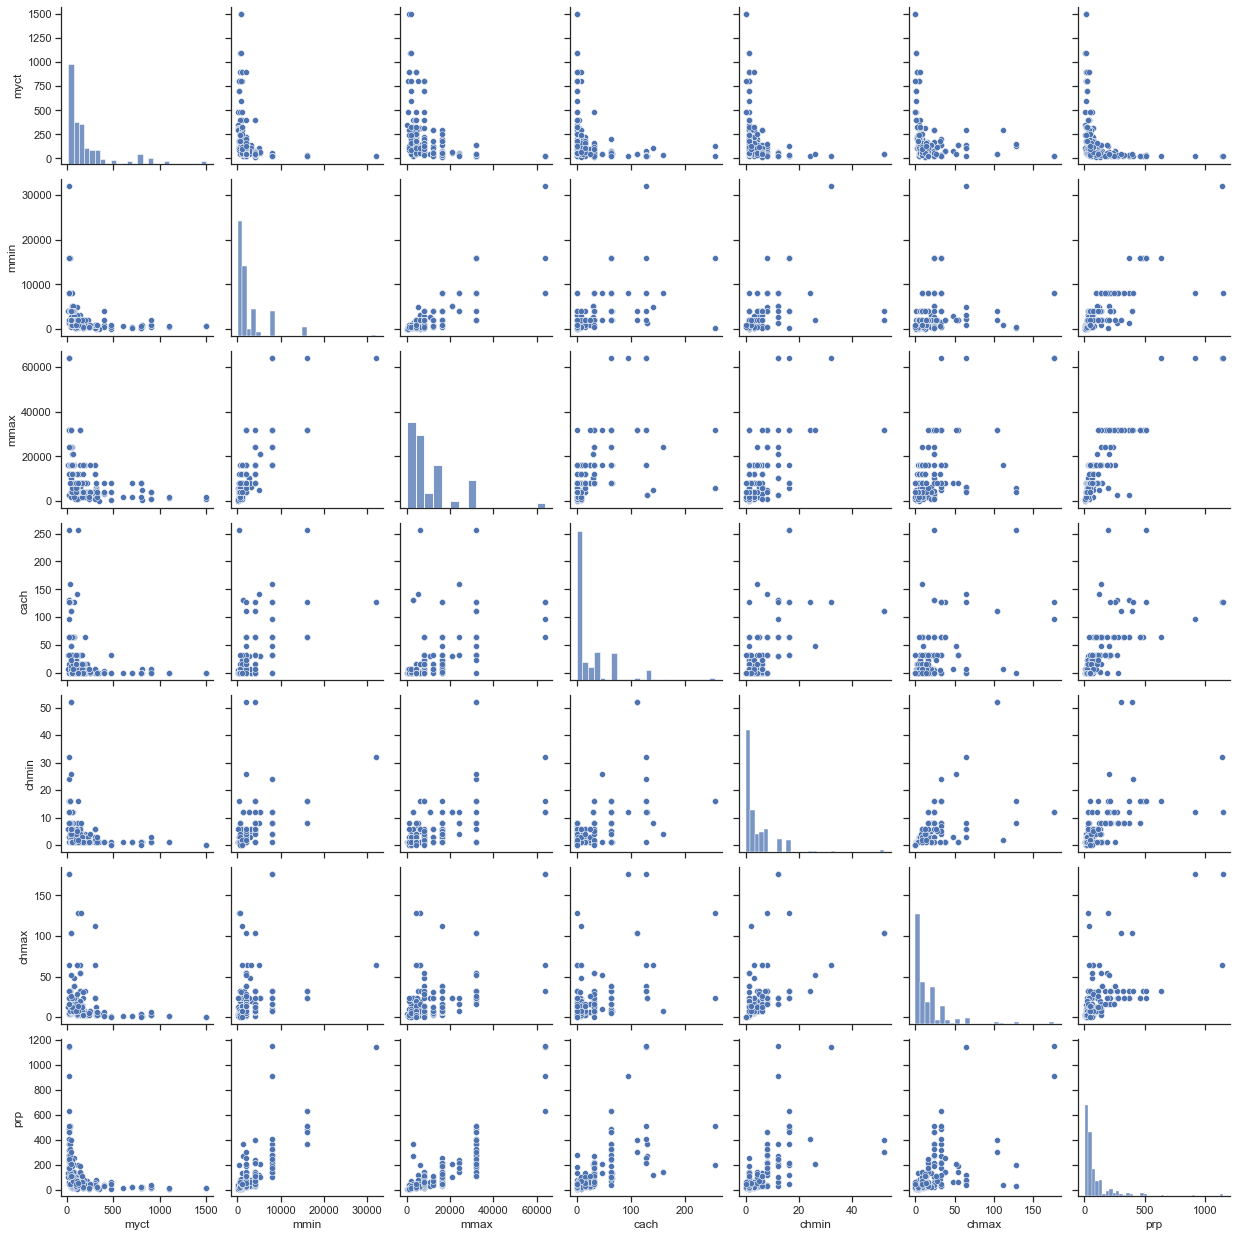

In [291]:
# pair plot
sns.pairplot(df)

There are three main concerns I have with this dataset, following this visualisation:
- Every variable appears to be left-skewed → may need to normalise data.
- There appear to be many outliers in the data → may need to use a scaler which can handle outliers well.
- Appears to be some strong correlation between features → may need to check for co-linearity and remove any co-linear
features.

### Scaling Data

Let's start by addressing the normalisation and scaling of the data.

First, we can see from the pair plot that the distributions are heavily left skewed, and we have few samples with high
values for most of the features.

One way of remedying this is by using *log transformation*. This process finds the natural log of each sample $$x_{i}$$,
and in doing so, converts the distributions of the samples to a roughly normal distribution.

In [292]:
# log transformation
df_log = df
for col in df_log.columns:
    df_log[col] = np.log(df_log[col]+1)

Again, let's visualise the feature distributions using a pair plot.

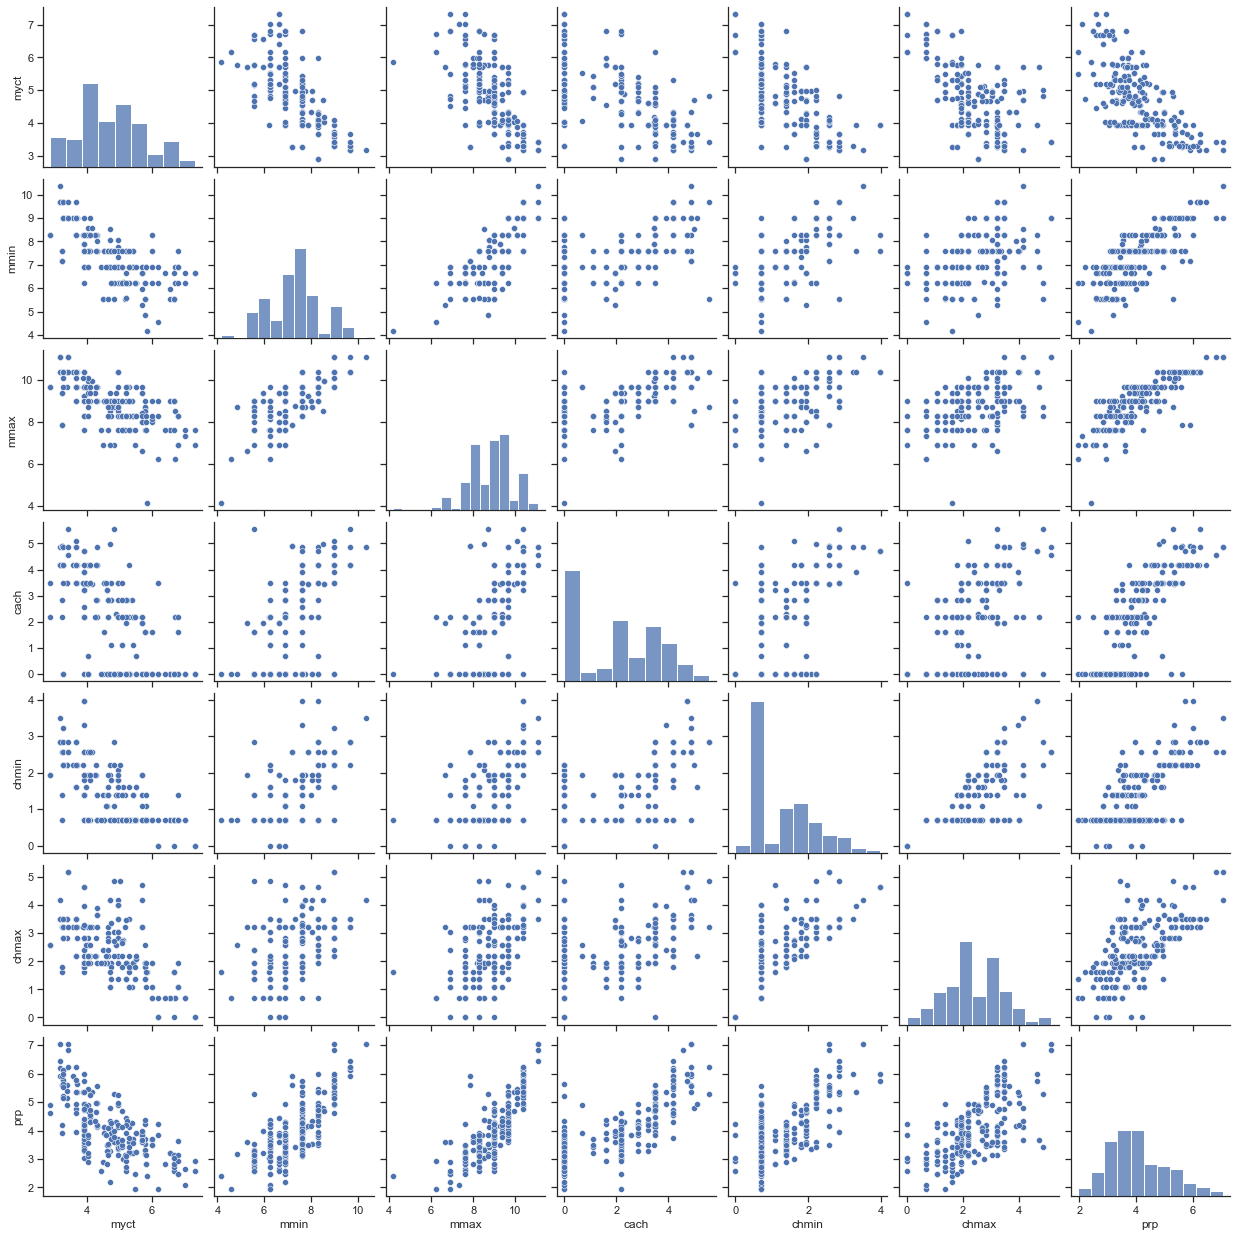

In [293]:
sns.pairplot(df_log)

Now our distributions are looking a little more "normal", we can normalise the data using the standard scaler.

In [294]:
std_scaler = StandardScaler()
df_std = pd.DataFrame(std_scaler.fit_transform(df_log), columns=df_log.columns)

One more time, let's look at the pair plot for our newly scales data, this time showing the kernel density estimation.

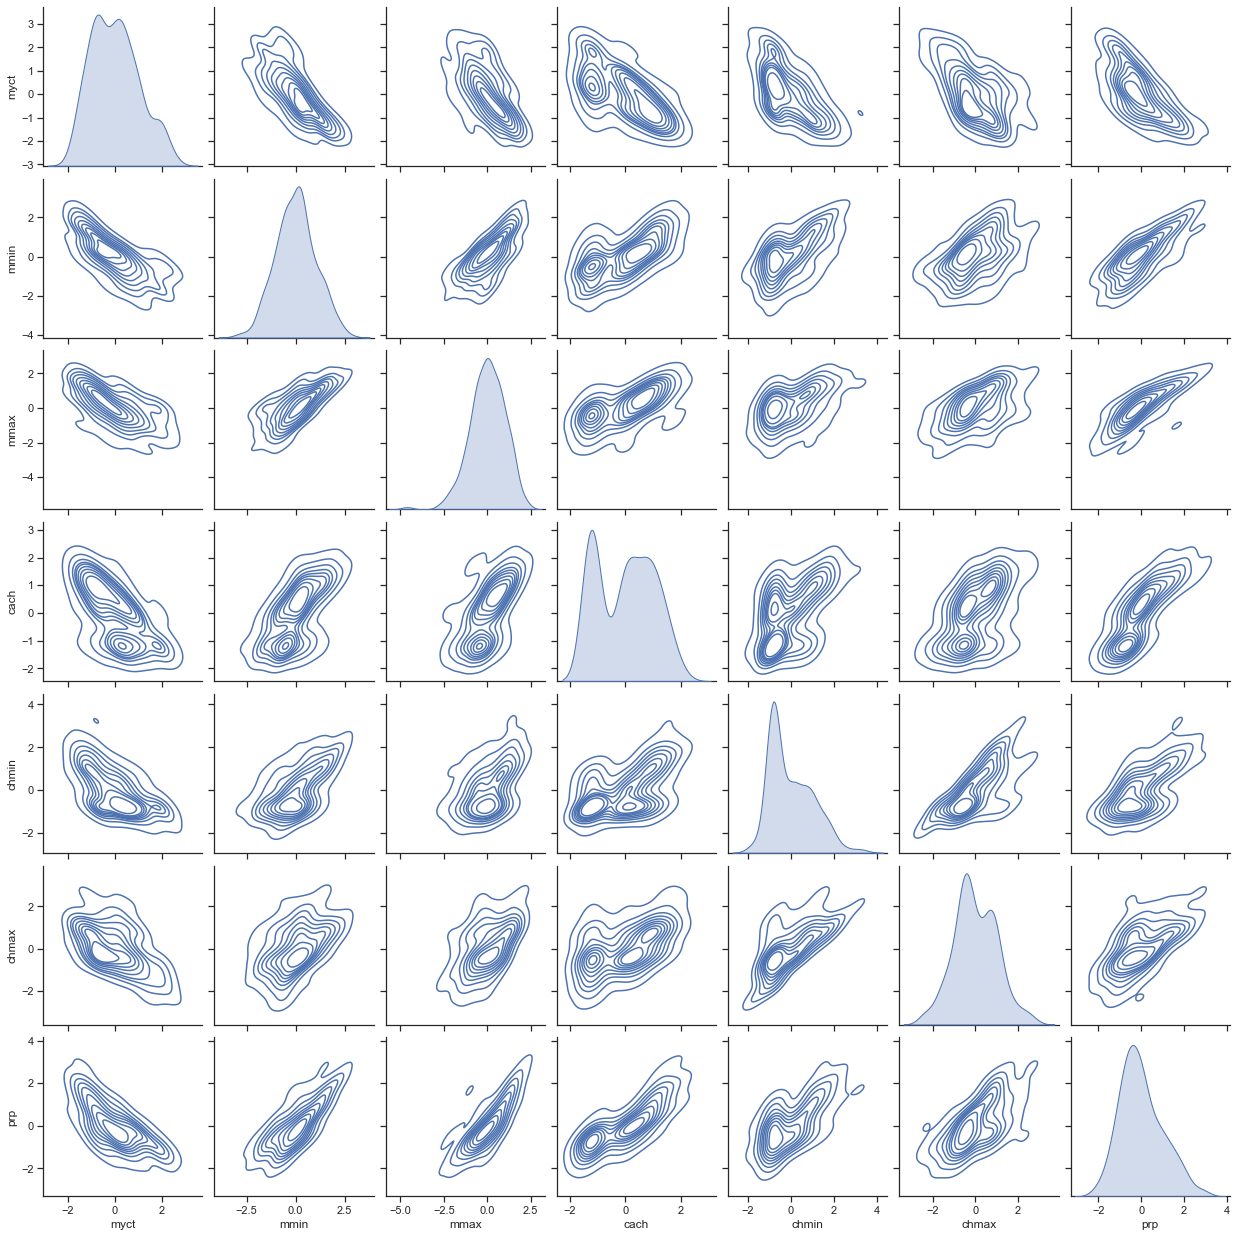

In [295]:
sns.pairplot(df_std, kind='kde')

### Co-linear Features

Now, let's address some of those highly correlated features I mentioned earlier.

We can view the correlation between the features and the target by calculating the correlation matrix from the data, and
plotting this as an annotated heatmap.


<AxesSubplot:>

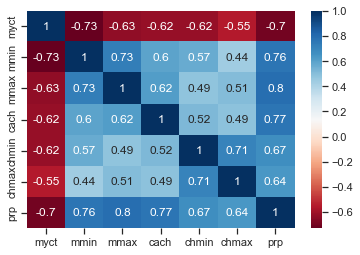

In [296]:
# correlation matrix
corr = df_std.corr()
sns.heatmap(corr, cmap='RdBu', annot=True)

Usually, co-linear features are two features with a correlation score greater or equal to 0.7, or less than or equal to
-0.7.

From the heatmap above, we can see that we have a couple of feature pairs which are co-linear by this definition.

Co-linear features can be problematic for some machine learning models, as the model may ascribe too much weight to a
co-linear feature.

One way we might seek to solve this is by simply removing some of the pesky co-linear features from the dataset. This
has the benefit of making a model simpler, which is *generally* a good thing. Let's see how we might go about removing
two of the co-linear features.

In [297]:
# # drop two of the co-linear features (usually the one of the pair which is least correlated to the target)
# df_dropped = df_std.drop(columns=['mmin', 'cach'])
#

In [298]:
# # correlation matrix
# corr = df_dropped.corr()
# sns.heatmap(corr, cmap='RdBu', annot=True)
#

Easy! Look at that! No more co-linear features, now our model will be perfect!

Maybe... or maybe not. While we may have removed features that needed removing, our choice was ultimately pretty
arbitrary and uninformed. We may have also removed a feature which was, in fact, the best predictor for our target. Or
perhaps we didn't need to remove the co-linear features at all in order to optimise our model's performance.

A far better way of reducing dimensionality is **Principle-Component Analysis** (or PCA for short).

### Principle-Component Analysis

In [299]:
# pca = PCA(n_components=len(df_std.columns))
#

In [300]:
# components = pca.fit(df_std).components_
#

In [301]:
# components = pd.DataFrame(components).transpose()
# components.columns = [f'comp_{i+1}' for i in range(len(df_std.columns))]
# components.index = df_std.columns
#
# # show principle-components dataframe
# display(components)
#

In [302]:
# var_ratio = pca.explained_variance_ratio_
#

In [303]:
# var_ratio = pd.DataFrame(var_ratio).transpose()
# var_ratio.columns = [f'comp_{i+1}' for i in range(len(df_std.columns))]
# var_ratio.index = ['Proportion of Variance']
#
# # show variance proportion dataframe
# display(var_ratio)
#

In [304]:
# # scree plot
#

In [305]:
# df_pcomp = pca.fit_transform(df_std)
# df_pcomp = pd.DataFrame(df_pcomp)
# df_pcomp = df_pcomp.iloc[:,0:5]  # num PCs to be determined from scree plot
# df_pcomp.columns = [f'comp_{i+1}' for i in range(5)]
#
# display(df_pcomp.head())
#

In [306]:
# # pair plot again
# sns.pairplot(df_pcomp)

In [307]:
# # splitting data
# X = df.drop(columns='prp').values
# y = df['prp'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [308]:
def transform_and_scale(inputs):
    input_df = pd.DataFrame(inputs)
    # log transform data
    for col in input_df.columns:
        input_df[col] = np.log(input_df[col]+1)
    # normalise (scale and zero centre) data
    std_scaler = StandardScaler()
    inputs = pd.DataFrame(std_scaler.fit_transform(input_df), columns=input_df.columns).values
    return inputs

In [309]:
def find_principle_components(scaled_inputs):
    pca = PCA(n_components=len(scaled_inputs.columns))
    return pd.DataFrame(pca.fit_transform(scaled_inputs)).iloc[:,0:5]

In [310]:
def get_predictions(train_inputs, test_inputs, train_output):

    # ML model
    rgr = LinearRegression()

    # train model
    rgr.fit(train_inputs, train_output)

    # get predictions
    y_hat = rgr.predict(test_inputs)

    return y_hat

In [311]:
def get_error(test_output, predictions, absolute=False):
    error = 0
    for y, y_hat in zip(test_output, predictions):
        if absolute:
            error += abs(y - y_hat)
        else:
            error += (y - y_hat) ** 2
    return 1/len(test_output) * error

In [312]:
def reduce_dimensions(data):

    # remove output column from dataframe
    y = data['prp'].values

    # get all possible feature combinations
    feature_sets = []
    for r in range(len(data.drop(columns='prp').columns) + 1):
        feature_set = itertools.combinations(data.drop(columns='prp').columns, r)
        feature_sets += list(feature_set)
    feature_sets = [list(feature_set) for feature_set in feature_sets if len(feature_set) > 0]

    i = 1
    results = {}

    for feature_set in feature_sets:

        # get reduced dimension inputs
        X = data[feature_set].values

        # scale input data
        X = transform_and_scale(X)

        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

        y_hat = get_predictions(X_train, X_test, y_train)
        mse = get_error(y_test, y_hat)
        rmse = np.sqrt(mse)
        mae = get_error(y_test, y_hat, absolute=True)

        results[f'feature_set{i}'] = {'features': ', '.join(feature_set),
                                      'mse': mse,
                                      'rmse': rmse,
                                      'mae': mae}

        i += 1

    return results

In [313]:
results = reduce_dimensions(df)

In [314]:
df_results = pd.DataFrame.from_dict(results).T.reset_index(drop=True)
display(df_results)

,features,mse,rmse,mae
0,myct,0.548398,0.740539,0.578069
1,mmin,0.517946,0.719684,0.535764
2,mmax,0.498034,0.705715,0.509227
3,cach,0.695284,0.833837,0.646248
4,chmin,0.675113,0.821653,0.645374
...,...,...,...,...
58,"myct, mmin, mmax, chmin, chmax",0.356385,0.59698,0.472732
59,"myct, mmin, cach, chmin, chmax",0.382105,0.618146,0.479255
60,"myct, mmax, cach, chmin, chmax",0.323009,0.568339,0.443236
61,"mmin, mmax, cach, chmin, chmax",0.316192,0.562309,0.432197


In [315]:
df_results_melt = df_results.melt(
    id_vars='features',
    value_vars=['rmse', 'mse', 'mae'],
    var_name='error_type',
    value_name='error_value'
)

In [316]:
fig = px.bar(
    df_results_melt,
    x = 'features',
    y = 'error_value',
    color = 'error_type',
    barmode = 'group',
)

fig.update_layout(
    height=750,
    width=1250
)

fig.show()

In [317]:
# get best scoring 10% of feature sets
display(df_results.sort_values(by='rmse').iloc[:round(0.1*len(df_results)), :].reset_index(drop=True))

,features,mse,rmse,mae
0,"myct, mmin, mmax, cach, chmax",0.300666,0.54833,0.425802
1,"myct, mmax, cach, chmax",0.305209,0.552458,0.4327
2,"mmin, mmax, cach, chmax",0.306875,0.553963,0.426883
3,"myct, mmin, mmax, cach, chmin, chmax",0.31321,0.559652,0.43115
4,"mmin, mmax, cach, chmin, chmax",0.316192,0.562309,0.432197
5,"myct, mmax, cach",0.317664,0.563616,0.437072


In [318]:
best_feature_sets = [row.features.split(', ') for row in df_results.sort_values(by='rmse').itertuples()][:6]
print('Best feature sets:')
for best_feature_set in best_feature_sets:
    print(best_feature_set)

Best feature sets:
['myct', 'mmin', 'mmax', 'cach', 'chmax']
['myct', 'mmax', 'cach', 'chmax']
['mmin', 'mmax', 'cach', 'chmax']
['myct', 'mmin', 'mmax', 'cach', 'chmin', 'chmax']
['mmin', 'mmax', 'cach', 'chmin', 'chmax']
['myct', 'mmax', 'cach']


---

## Principal Component Analysis

Whilst straight forward dimension reduction can improve the error of our linear regression model, and make our model
simpler and easier to interpret, we may be able to achieve a lower error by performing principal component analysis
(PCA).

PCA is *not* a method of dimension reduction. It may be that after performing PCA we end up with fewer features to pass
to our model, but this is not the main goal. Instead, PCA basically focuses on finding *combinations of features* which
yield better results than the raw features. These new features are termed **principal components**.

After determining these principal components, we then seek to find those which contribute most to our model's
predictions.

Here's a good video explaining the basics of PCA which I found helpful when learning about the concept.

In [330]:
X = df.drop(columns='prp').values
y = df['prp'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [331]:
pca = PCA(n_components=len(df.columns)-1).fit(X_train)

In [332]:
components = pca.components_

In [333]:
# projecting unknown data to pca transformed feature space
X_test_pca_transformed = pca.transform(X_test)

